# Optimal Control: Sink+Rotation Flow

In [1]:
# start and end points
xA = 1/2
yA = sqrt(3)/2

xB = 1.0
yB = 0.0

# velocity and vorticity fields
u(x,y,t) = -0.3*x+(t-0.5)*y
v(x,y,t) = -0.3*y+(0.5-t)*x
vort(x,y,t) = 1-2*t

# optimal control and travel time
θ = -0.775432
T = 1.03008

x(t, ang, x0, y0) = (exp(-0.3*t)/3)*(3*x0*cos(t*t/2-t/2)+10*(exp(0.3*t)-1)*cos(t*t/2-t/2-ang)+3*y0*sin(t*t/2-t/2))
y(t, ang, x0, y0) = (exp(-0.3*t)/3)*(3*y0*cos(t*t/2-t/2)-10*(exp(0.3*t)-1)*sin(t*t/2-t/2-ang)-3*x0*sin(t*t/2-t/2))

nothing

### Optimal Trajectory + Perturbations (Noise)

In [2]:
# array for all tracks
x_tracks = []
y_tracks = []

# points for separate tracks
x1_points = []
y1_points = []

x2_points = []
y2_points = []

x3_points = []
y3_points = []

x4_points = []
y4_points = []

x0_points = []
y0_points = []

Δt = T/240
ϵ = (pi/180)
Δ = 0.025

for i in 1:240
    x0_now, y0_now = x(i*Δt, θ, xA, yA), y(i*Δt, θ, xA, yA)
    push!(x0_points, x0_now)
    push!(y0_points, y0_now)

    x1_now, y1_now = x(i*Δt, θ+ϵ, xA, yA), y(i*Δt, θ+ϵ, xA, yA)
    push!(x1_points, x1_now)
    push!(y1_points, y1_now)

    x2_now, y2_now = x(i*Δt, θ-ϵ, xA, yA), y(i*Δt, θ-ϵ, xA, yA)
    push!(x2_points, x2_now)
    push!(y2_points, y2_now)

    x3_now, y3_now = x(i*Δt, θ, xA+Δ, yA), y(i*Δt, θ, xA+Δ, yA)
    push!(x3_points, x3_now)
    push!(y3_points, y3_now)

    x4_now, y4_now = x(i*Δt, θ, xA, yA+Δ), y(i*Δt, θ, xA, yA+Δ)
    push!(x4_points, x4_now)
    push!(y4_points, y4_now)
end

push!(x_tracks, x1_points)
push!(y_tracks, y1_points)

push!(x_tracks, x2_points)
push!(y_tracks, y2_points)

push!(x_tracks, x3_points)
push!(y_tracks, y3_points)

push!(x_tracks, x4_points)
push!(y_tracks, y4_points)

push!(x_tracks, x0_points)
push!(y_tracks, y0_points)   

nothing

i = 60
i = 120
i = 180
i = 240


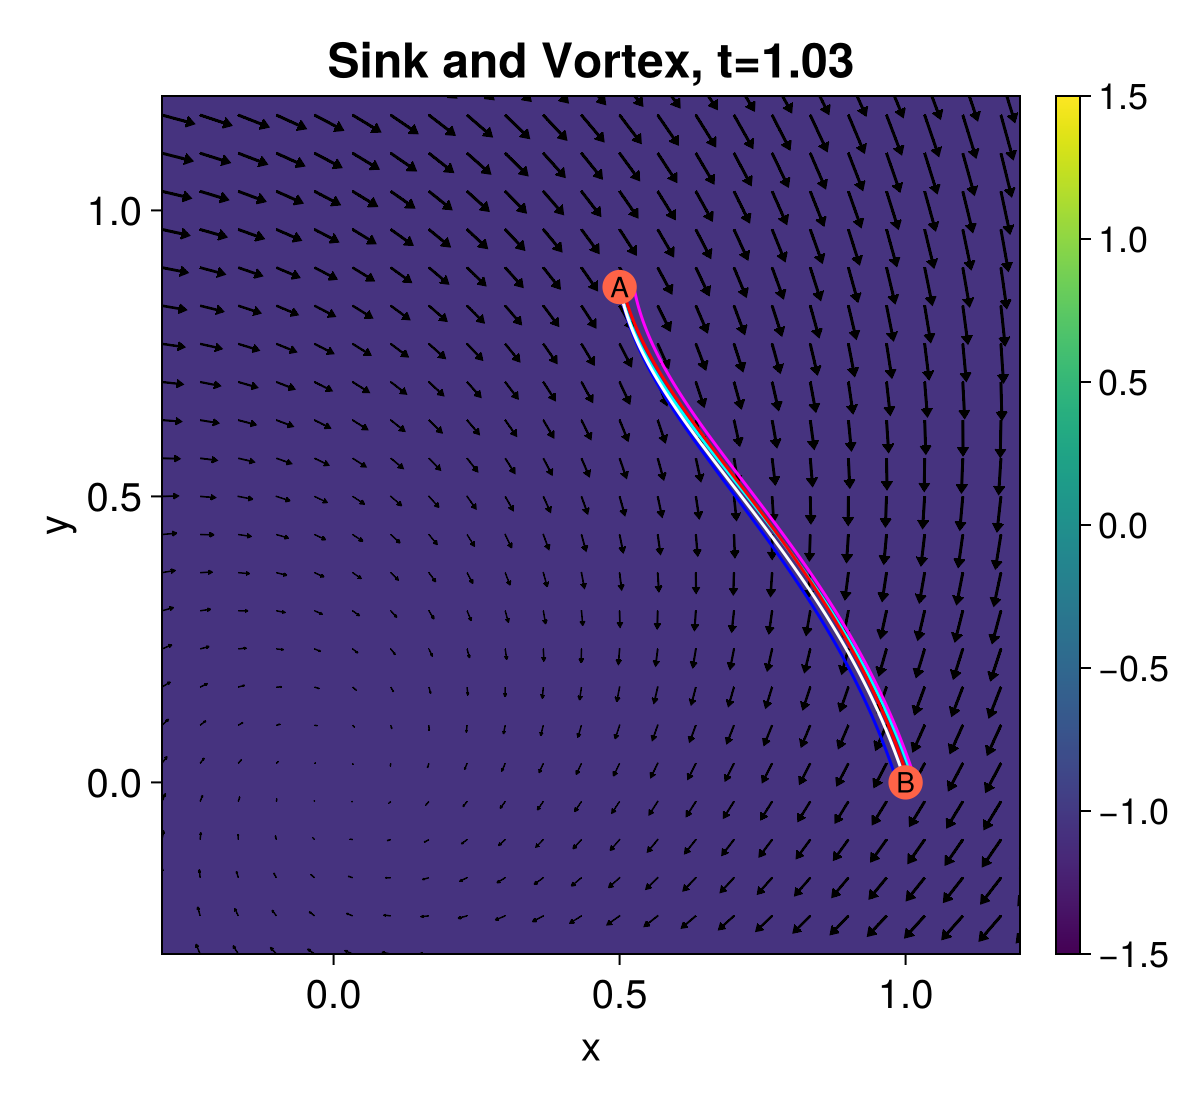

In [3]:
using CairoMakie, Printf

Δt = T/240

frame = Observable(1)
tau = @lift($frame*Δt)

xs = range(-0.5, 1.5, length=200)
ys = range(-0.5, 1.5, length=200)
zs = @lift([vort(x,y, $tau) for x in xs, y in ys])

xs2 = LinRange(-0.5, 1.5, 31)
ys2 = LinRange(-0.5, 1.5, 31)
us2 = @lift([u(x,y, $tau) for x in xs2, y in ys2])
vs2 = @lift([v(x,y, $tau) for x in xs2, y in ys2])

points_list = Any[]

for p in 1:5
    points = Observable(Point2f[(xA, yA)])
    push!(points_list, points)
end


fig = Figure(size = (600, 550))

ax = Axis(fig[1, 1],
    title = @lift("Sink and Vortex, t="*@sprintf("%.2f", $tau)), titlesize=24,
    xlabel = "x", xlabelsize=20, xticklabelsize=20,
    ylabel = "y", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((-0.3, 1.2), (-0.3,1.2))
)

hm = heatmap!(ax, xs, ys, zs, colormap = :viridis, alpha=1.0, colorrange=(-1.5, 1.5))
Colorbar(fig[:, end+1], hm, ticklabelsize=18)

arrows2d!(ax, xs2, ys2, us2, vs2, lengthscale = 0.08, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

lines!(ax, points_list[1], color=:cyan)
lines!(ax, points_list[2], color=:blue)
lines!(ax, points_list[3], color=:magenta)
lines!(ax, points_list[4], color=:red)
lines!(ax, points_list[5], color=:white)
    
poly!(ax, Circle(Point2f(xA, yA), 0.03), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center))

poly!(ax, Circle(Point2f(xB, yB), 0.03), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center))


frames = 1:240

record(fig, "Sink+Rotation.mp4", frames; framerate = 20) do i
    mod(i, 60) == 0 && @show i
    frame[] = i

    for (idx, points) in enumerate(points_list)
        new_point = Point2f(x_tracks[idx][i], y_tracks[idx][i])
        points[] = push!(points[], new_point)
    end
end

save("sink+rotation.pdf", fig)
fig